In [61]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\nawil\AppData\Local\Temp\pip-install-xoitoer9\tensorflow-gpu_4825d60a1c1d4ff2805e6b34637abe6a\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-e

https://github.com/nicknochnack/FaceDetection/blob/main/FaceDetection.ipynb

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [6]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print('cant open cam')
    exit()
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    while ret == False:
        print("retrying frame")
        cap.release()
        cap = cv2.VideoCapture(0)
        ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    #cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [8]:
!labelme

In [10]:
120 *.7 #84 for train


84.0

In [11]:
120 * .15 #18 for test and val

18.0

In [18]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [41]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)
#images.as_numpy_iterator().next()

def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

images = images.map(load_image)
#images.as_numpy_iterator().next()

type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [42]:
image_generator = images.batch(4).as_numpy_iterator()

In [53]:
plot_images = image_generator.next()

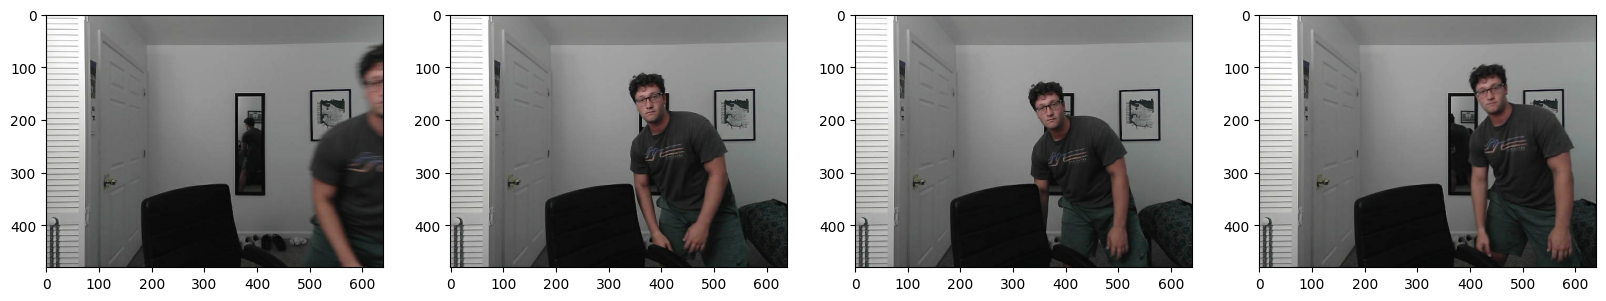

In [54]:
fig, ax = plt.subplots(ncols=4, figsize =(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [12]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

Start Augmenting

In [13]:
import albumentations as alb

In [14]:
augmentor= alb.Compose([alb.RandomCrop(width=450, height=450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [16]:
img = cv2.imread(os.path.join('data','train', 'images', '7f940a20-fbda-11ed-afba-8cb87e55bbac.jpg'))

In [19]:
with open(os.path.join('data', 'train', 'labels', '7f940a20-fbda-11ed-afba-8cb87e55bbac.json'), 'r') as f:
    label = json.load(f)

In [20]:
label['shapes'][0]

{'label': 'face',
 'points': [[428.6734693877552, 163.97959183673467],
  [521.530612244898, 298.67346938775506]],
 'group_id': None,
 'description': '',
 'shape_type': 'rectangle',
 'flags': {}}

In [21]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [23]:
coords = list(np.divide(coords, [640,480,640,480]))

In [24]:
coords

[0.6698022959183675,
 0.3416241496598639,
 0.8148915816326531,
 0.6222363945578231]

In [26]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [29]:
augmented['bboxes']

[(0.7281632653061226,
  0.34884353741496593,
  0.9345124716553288,
  0.6481632653061223)]

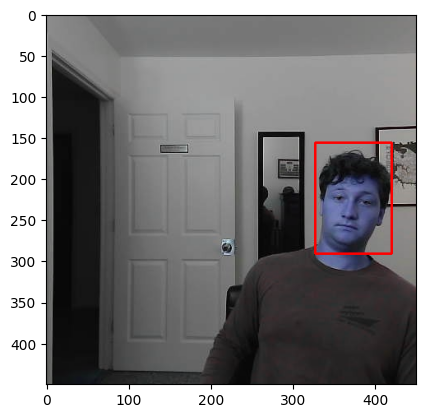

In [30]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

Build and run Augmentation Pipeline